In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/train/09839ef1c5a5a5b3acb61c4093cab07f.jpg
/kaggle/input/dog-breed-identification/train/dd126e42b474c3831f8fda33052428c1.jpg
/kaggle/input/dog-breed-identification/train/b3e3556e19d2d067314dcbfecf2ab7b7.jpg
/kaggle/input/dog-breed-identification/train/17e00d79ad69729522d8705e95939f01.jpg
/kaggle/input/dog-breed-identification/train/8352ccfcb4f7024272f660d1e3525f30.jpg
/kaggle/input/dog-breed-identification/train/7ccda9a3e0a1c771f7bebc04f0b6bb0f.jpg
/kaggle/input/dog-breed-identification/train/03f2f64aebc483ef8e5e17aba7311aa6.jpg
/kaggle/input/dog-breed-identification/train/e9fc775bd40d6d7273ff093fa12a0574.jpg
/kaggle/input/dog-breed-identification/train/351f02bbaa4f24bad17cc1e83c39a0fc.jpg
/kaggle/input/dog-breed-identification/train/cd806882f79da1043e04c70888865c7e.jpg
/kaggle/input/dog-breed-identification/train/b02fdd22c35b59fc509d27e1

# End to End Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub

## 1. Problem
Identifying the breed of a dog, given the image of a dog.

## 2. Data
Data is available in this competition

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

## Features
This is unstructured data, since we're dealing with images here, so it is a deep learning problem. 

## Importing the necessary libraries

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import matplotlib.pyplot as plt
print('TensorFlow Version :', tf.__version__)
print('TensorFlow_Hub Version :', hub.__version__)

# Check if we're using GPU
print('GPU','Available!!, Noice' if tf.config.list_logical_devices('GPU') else 'Not Available')

TensorFlow Version : 2.3.0
TensorFlow_Hub Version : 0.8.0
GPU Available!!, Noice


## Getting our data(images) ready, by converting it into tensors.

Let's take a look at our labels.

In [3]:
labels_csv = pd.read_csv('../input/dog-breed-identification/labels.csv')

In [4]:
labels_csv[70:80]

id                breed
70  01b36cb1b80ab8c3a7d2b7128ad21bdc              samoyed
71  01b6c2bd3053535a58d8de763cf06aa0  miniature_schnauzer
72  01b849a7e4fbc545f6b2806cb87ab371     brittany_spaniel
73  01c230ec18eed427cf5b1db1a833024d       english_setter
74  01d0f3692e576b3cde511285352aed4a               kelpie
75  01de1f7b7b4465a6d130a56746af66a6             papillon
76  01dffcb02d6cba7d2b101fcc93daa6f1        border_collie
77  01e2245b46eb747260ff80f1c892daef     brittany_spaniel
78  01e4d3d1cb704ed819bce35d22e716a7          appenzeller
79  01e787576c003930f96c966f9c3e1d44   scottish_deerhound

### EDA

In [5]:
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     f485d0ea64f8950b38954c17cfd03d8f  scottish_deerhound
freq                                   1                 126

* Let's take a look at most common dog breed.
* Also this helps us figure out number of images for each breed.

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
pomeranian              111
great_pyrenees          111
basenji                 110
samoyed                 109
Name: breed, dtype: int64


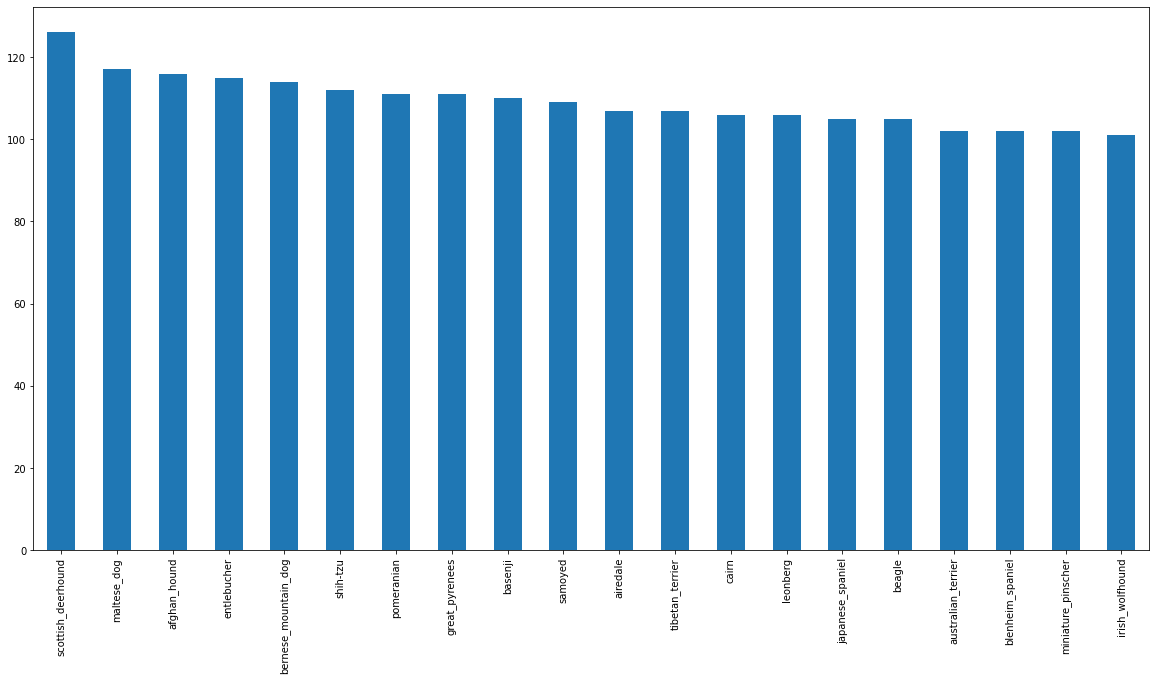

In [6]:
print(labels_csv['breed'].value_counts()[:10])
labels_csv['breed'].value_counts()[:20].plot.bar(figsize=(20,10))

Hmmm, looks like these are the top 5 most common dog breeds in this data :


 `scottish_deerhound      126
 maltese_dog             117
 afghan_hound            116
 entlebucher             115
 bernese_mountain_dog    114`

* Overall frequency of `breed` column

82.0


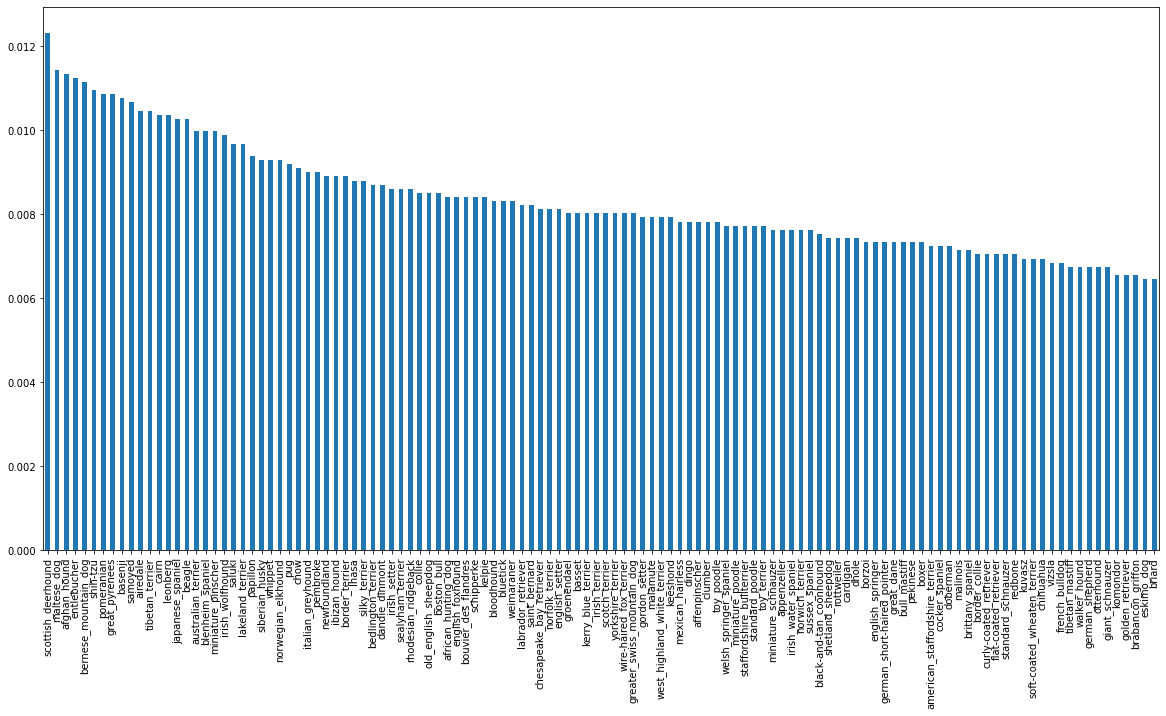

In [7]:
labels_csv['breed'].value_counts(normalize=True).plot.bar(logx=False, figsize=(20,10))
print(labels_csv['breed'].value_counts().median())

We should know that for model training purposes, it's recommended that we use about 100 annotations per label, with minumum of 10 annotations.

What it means is, if we had atleast 100 values/images per each breed, our model would learn really good. 

But that's not the case here. We have roughly 82 images per breed.

Anyway, let's continue.

Let's try and view an image.

Since `scottish_deerhound` is the most common breed, let's take a look at it.

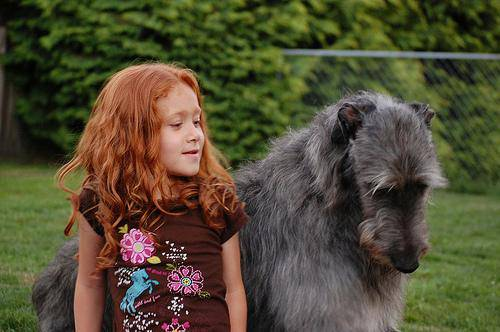

In [8]:
Image('../input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg')

Let's look at another image,

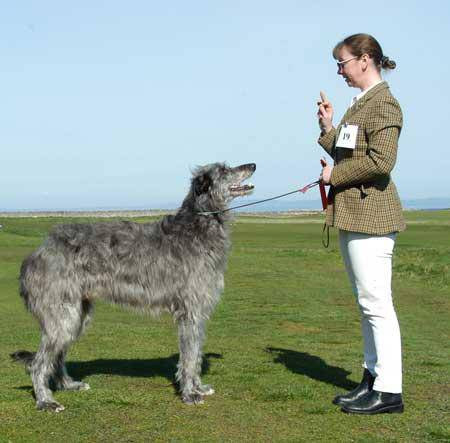

In [9]:
Image('../input/dog-breed-identification/train/01e787576c003930f96c966f9c3e1d44.jpg')

Now as humans, we can identify some patterns/features of this breed. 

Let's look at some of the features of this breed :

1. It looks like a large greyhound cloaked in a wiry coat. 
2. This breed has long, slender legs, like a greyhound.
3. It has relatively narrow body, deep chest, tucked abdomen, arched loin      and long tail.
4. It is Dolichocephalic (long face).

Now let's see if our model can similarly figure out different features from this data.

Now let's map `images` and their `labels` 

In [10]:
# Create pathnames from image ID's
filenames = []

In [11]:
filenames = []
for filename in labels_csv['id']:
    filenames.append('../input/dog-breed-identification/train/' + filename + '.jpg')
filenames[:10]

['../input/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '../input/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '../input/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '../input/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '../input/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '../input/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '../input/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '../input/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '../input/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '../input/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [12]:
# Check if number of filenames are equal to number of actual image files.
import os
if len(os.listdir('../input/dog-breed-identification/train/')) == len(filenames):
    print('Yes ! they match')
else:
    print('No, they don\'t')

Yes ! they match


Awesome, number of filenames are equal to number of image files.

Let's make one last check.

tibetan_mastiff


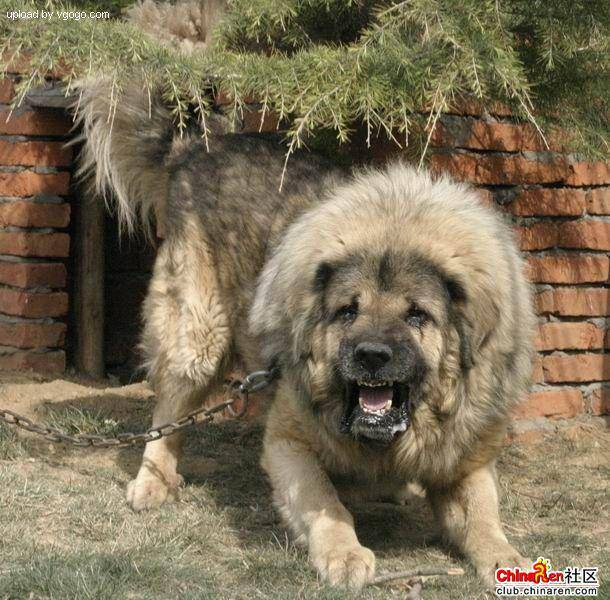

In [13]:
print(labels_csv['breed'][9000])
Image(filenames[9000])

WOAHHH ! What a beast, looks like a lion.

Since we've a list of training image filepaths, it's time to prepare our labels.

In [14]:
labels = labels_csv['breed']
labels = np.array(labels)
labels

# Or we can ,
# labels = labels_csv['breed'].to_numpy()

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [15]:
len(labels)

10222

Now in case we had structured data, in order to find the missing values, we had `df.isnull().sum()`.

But since we're dealing with unstructured data, we have to check for missing values by comparing length of `filenames` and `labels`.

In [16]:
# Check if number of labels are equal to number of filenames.
import os
if len(filenames) == len(labels):
    print('Yessssss ! no missing values ;-)')
else:
    print('Nooooo ! Look\'s like we have missing values to deal with')

Yessssss ! no missing values ;-)


Beautiful, looks like we don't have any missing data.

In [17]:
# Let's find unique label values.
unique_breeds = np.unique(labels)
unique_breeds


array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [18]:
len(unique_breeds)

120

Awesome ! Since we had 120 breed of dogs.

Now let's turn labels into boolean array.

In [19]:
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [20]:
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

## Creating a validation set

In [21]:
from sklearn.model_selection import train_test_split
X = filenames
y = boolean_labels

Let's first train on 1000 images.

In [22]:
# Splitting into train and validation set.
X_train, X_valid, y_train, y_valid = train_test_split(X[:1000], y[:1000], test_size = 0.2, random_state = 42)

# Checking the dimensions of train and validation set
len(X_train), len(X_valid), len(y_train), len(y_valid)

(800, 200, 800, 200)

In [23]:
# Let's look if everything is fine.
X_train[:1], y_train[:1]

(['../input/dog-breed-identification/train/00bee065dcec471f26394855c5c2f3de.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, Fa

## Preprocessing the images.

It's time to convert images into tensors :
1. Take an image filepath as input
2. Use tensorflow to read the file and save it to a variable, `image`.
3. Turn `image` ('.jpg') into tensor
4. Normalize image (convert colour channels from 0-255 to 0-1
5. Resize `image` to a shape of (224, 224)
6. Return the modified `image`.

Now before that, let's import an image

In [24]:
from matplotlib.pyplot import imread
image = imread(filenames[30])
image.shape

(338, 450, 3)

In [25]:
image.max(), image.min()

(255, 0)

We can almost convert anything into a tensor using `tf.constant()`

In [26]:
tf.constant(image)

<tf.Tensor: shape=(338, 450, 3), dtype=uint8, numpy=
array([[[171, 115,  78],
        [170, 114,  77],
        [168, 114,  76],
        ...,
        [193, 165,  91],
        [187, 169,  93],
        [187, 169,  93]],

       [[172, 116,  79],
        [171, 115,  78],
        [169, 115,  77],
        ...,
        [198, 170,  96],
        [193, 174,  98],
        [193, 174,  98]],

       [[174, 118,  81],
        [173, 117,  80],
        [171, 117,  79],
        ...,
        [202, 174, 100],
        [196, 176, 103],
        [196, 176, 103]],

       ...,

       [[ 66,  46,  13],
        [ 71,  51,  18],
        [ 78,  59,  26],
        ...,
        [ 76,  33,  17],
        [ 84,  49,  27],
        [ 84,  49,  27]],

       [[ 72,  50,  13],
        [ 69,  47,  10],
        [ 80,  58,  21],
        ...,
        [ 74,  31,  15],
        [ 79,  47,  26],
        [ 82,  50,  29]],

       [[ 72,  50,  13],
        [ 69,  47,  10],
        [ 80,  58,  21],
        ...,
        [ 74,  31,  1

In [27]:
# Define image size
#IMG_SIZE = 224

# Create a function that preprocessess images
def image_process(image_path):
    '''
    Takes an image filepath and converts image into a tensor
    '''
    # Read image file
    image = tf.io.read_file(image_path)
    
    # Turn the jpg image into numerical tensor with 3 colour channels (red, green, blue)
    image = tf.image.decode_jpeg(image, channels = 3)
    
    # Convert the colour channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image (224,224)
    image = tf.image.resize(image, size = [224,224])
    
    return image

## Turning data into batches (default=32)

If you're trying to process 10222 images in one go, they won't fit into the memory.

Hence process 32 images at a time.

In order to use tensorflow effectively, our data has to be in the form of tensor tuples, like this :
`(image, label)`

In [28]:
# Creating a function that return a tuple of image and tensor [(image, tensor)]
def get_image_label(image_path, label):
    '''
    Takes an image filepath name and the associated label,
    processes the image and returns a tuple of (image, label)
    '''
    image = image_process(image_path)
    return image, label

Now that we've converted our data into tuple of tensors `(image, label)`, let's turn all of our data(`X & y`) into batches.

In [29]:
# Creating a function to turn data into batches.
def data_batcher(X, y=None, batch_size = 32, valid_data = False, test_data = False):
    '''
    Creates batches of data out of image (X) and label (y) pairs.
    It shuffles if it's training data, but won't if it's validation data.
    Also accepts test data as input (it doesn't have labels).
    '''
    
    # If the data is test data, we won't have labels
    if test_data:
        print('Creating test data batches...')
    
        # Only filepaths, not labels
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(image_process).batch(32)
        return data_batch

    # If the data is valid dataset, we don't shuffle it.
    elif valid_data:
        print('Creating validation data batches...')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y)))# labels
        data_batch = data.map(get_image_label).batch(32) 
        return data_batch
    # If the data is training data set
    else:
        print('Creating training data batches...')
        # Turn filepaths and labels into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        
        # Shuffle the pathnames and labels before mapping image processor function
        # ... is faster than shuffling images
        data = data.shuffle(buffer_size = len(X))
        
        # Create a image, label tuple and turns the image path into a preprocessed image
        data = data.map(get_image_label)
        
        # Turning the training data into batches.
        data_batch = data.batch(32) 
    return data_batch

In [30]:
# Create training and validation data batches.
train_data = data_batcher(X_train, y_train)
val_data = data_batcher(X_valid, y_valid, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [31]:
# Check different attributes of our data batches.
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Although our data is now in batches, it can be hard to understand.

So let's visualize it.

In [32]:
# Creating a function to view images in a data batch
def show_lim_images(images,labels):
    '''
    Displays a plot of given number of images and their labels from a data batch.
    '''
    # Setting up the fig
    plt.figure(figsize=(10,10))
    # Loop through 25 for displaying 25 images
    for i in range(25):
        #create subplots (5 rows, 5 columns)
        ax = plt.subplot(5,5,i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image lable as title.
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the gridlines off
        plt.axis('off')

Now let's visualize it.

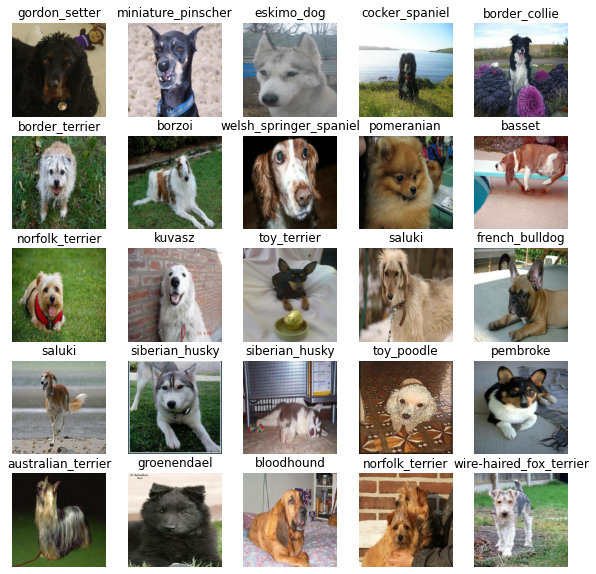

In [33]:
train_images, train_labels = next(train_data.as_numpy_iterator()) 
show_lim_images(train_images, train_labels)

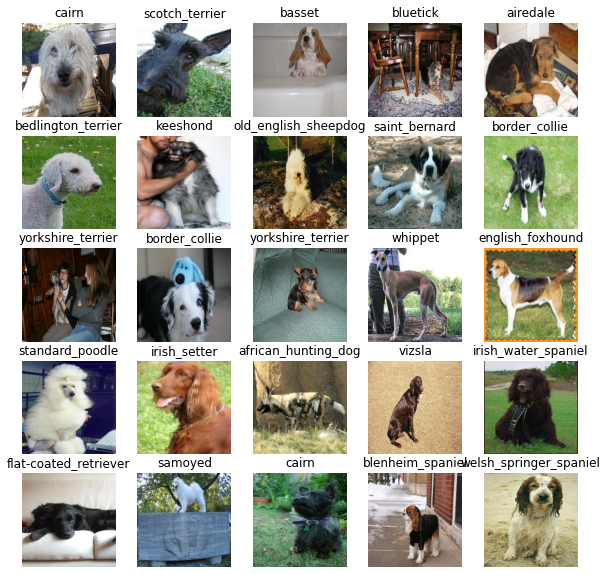

In [34]:
valid_images, valid_labels = next(val_data.as_numpy_iterator()) 
show_lim_images(valid_images, valid_labels)

## Building the model

Before building a model, let's define a few things
1. The input shape(our images in tensors) to our model.
2. The output shape(image labels, in tensors) of our model.
3. URL of the model we want to use : https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4

In [35]:
# Setup input shape to the model.
INPUT_SHAPE = [None, 224, 224,3] #batch, height, width, colour channels.
# Setup the output shape of the model.
OUTPUT_SHAPE = len(unique_breeds)
# Setup model URL from tensorflow hub.
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4'

Now that we've our inputs, outputs and model all set up, let's use `Keras` api from `TensorFlow` for creating deep learning model.

Let's create a function which:
1. Takes input, output shape along with model we've chosen.
2. Defines layers in the `Keras` model(Sequential fashion).
3. Compiles the model.
4. Builds the model.
5. Returns the model.

Source : https://www.tensorflow.org/guide/keras/overview

In [36]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print('Building model with : ', MODEL_URL, '...')
    
    #Setting up the model layers
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL), #1st layer/input layer
        tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                              activation='softmax')])#2nd/output layer
    
    # Compiling the model
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
        
    # Building the model
    model.build(INPUT_SHAPE)
    
    return model    

In [37]:
model = create_model()
model.summary()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 ...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Callbacks

Callbacks are like checkpoints that we have in games, it checks progress or stop training if there's no significant improvement in model.

So now we create a callback, 
* To stop the model early, if it's training for too long, because that'll lead to overfitting.


### Stopping Callback

Sometimes the model keeps on training evem though there is no improvement, which will cause overfitting. At times like that we use a callback to stop the model to train.

In [38]:
# Create early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) 

## Training

Now we won't train on all of our data, just 1000 images (800-training, 200-validation), As this will save us time.

The final parameter we'll define before training is NUM_EPOCHS (also known as number of epochs).

NUM_EPOCHS defines number of passes of the data we'd like our model to do.

In [39]:
# Build a function to train and return a trained model (100 epochs)
def train_model():    
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model()
    
    # Create new TensorBoard session everytime we train a model
    #tensorboard = create_tf_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data,
          epochs=100,
          validation_data=val_data,
          validation_freq=1, # check validation metrics every epoch
          callbacks=[early_stopping])
  
    # Return the fitted model.
    return model

In [40]:
# Fit the model to the data
model = train_model()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 ...
Epoch 1/100
25/25 [==============================] - 6s 256ms/step - loss: 4.5485 - accuracy: 0.1125 - val_loss: 3.5995 - val_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 3s 111ms/step - loss: 1.6387 - accuracy: 0.6800 - val_loss: 2.2854 - val_accuracy: 0.5250
Epoch 3/100
25/25 [==============================] - 3s 107ms/step - loss: 0.5767 - accuracy: 0.9212 - val_loss: 1.7514 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 3s 115ms/step - loss: 0.2530 - accuracy: 0.9887 - val_loss: 1.5715 - val_accuracy: 0.6000
Epoch 5/100
25/25 [==============================] - 3s 120ms/step - loss: 0.1482 - accuracy: 0.9950 - val_loss: 1.4949 - val_accuracy: 0.6150
Epoch 6/100
25/25 [==============================] - 3s 116ms/step - loss: 0.1007 - accuracy: 1.0000 - val_loss: 1.4607 - val_accuracy: 0.6400
Epoch 7/100
25/25 [========================

Looking at the accuracy and difference between accuracy and val_accuracy, it seems that the model is overfitting.

While it is doing exceptionally good on training data, it's not doing that good on validation data.

## Predictions

Making predictions with our model returns an array with a different value for each label.

In this case, making predictions on the validation data (200 images) returns an array (predictions) of arrays, each containing 120 different values (one for each unique dog breed).

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

In [41]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions[0] # Predictions of one image

7/7 [==============================] - 1s 75ms/step


array([5.94907266e-04, 7.31495384e-05, 1.98978116e-03, 1.15944262e-04,
       3.02906818e-04, 1.26527346e-04, 2.55015753e-02, 5.02643525e-05,
       8.45962277e-05, 1.45871250e-03, 1.21958059e-04, 7.48717357e-05,
       3.92565154e-04, 1.00240914e-05, 5.10070124e-04, 1.83578668e-04,
       1.44303762e-04, 3.15387964e-01, 8.59260035e-06, 4.70361520e-05,
       2.80014268e-04, 2.48116528e-04, 1.83748471e-05, 1.13431097e-03,
       1.49026018e-05, 8.20605201e-05, 2.21430540e-01, 8.75852784e-05,
       1.49751679e-04, 6.84587358e-05, 1.19136079e-04, 4.36867529e-04,
       2.45270785e-04, 4.21807090e-05, 2.11400038e-05, 7.21885776e-03,
       1.23696273e-05, 2.29754485e-04, 2.94515019e-04, 3.38152167e-05,
       3.97934433e-04, 2.80150089e-05, 1.88946833e-05, 4.60155825e-05,
       6.81712618e-06, 1.13903725e-05, 4.81128845e-05, 2.32754595e-04,
       1.84973865e-03, 4.83488053e-04, 4.87663601e-05, 8.58375133e-05,
       3.56092438e-04, 2.89587388e-05, 1.75386358e-05, 4.32503984e-05,
      

In [42]:
def pred(index):
    '''
    Takes index value from the predictions and returns 
    highest confidence level index of the highest confidence value
    and dog breed.
    '''
    max_value = np.max(predictions[index])
    max_value_index = predictions[index].argmax()
    breed_at_that_index = unique_breeds[max_value_index]
    print(f"Confidence Level for first image : {max_value}")
    print(f"Index for the Max Value : {max_value_index}")
    print(f"Breed at that Index :  {breed_at_that_index}")

In [43]:
pred(0)

Confidence Level for first image : 0.3153879642486572
Index for the Max Value : 17
Breed at that Index :  border_terrier


Hmmm, lets see according to the model, it's highly probable that the dog in the first image is a `cairn`, with a confidence of 45.13%.  Now this is variable, because we've shuffled the training data.

Now let's take our `val_data`(which is in batches) and get a list of it, or basically unbatch it.

In [44]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[0])

In [45]:
# Create a function to unbatch.
def unbatch(data):
    '''
    Takes a dataset(which is in batches), and unbatches it. 
    '''
    images = []
    labels = []
    for image, label in data.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(unique_breeds[np.argmax(label)])
    return images, labels

In [46]:
val_images, val_labels = unbatch(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

## Let's visualize the predictions.

Now we've got ways to get:
1. Prediction labels
2. Validation labels(truth labels)
3. Validation images

Lets visualize it with a function.

In [47]:
def plot(pred_probs, labels, images, n=1):
    '''
    View prediction, actual truth, and image for sample n
    '''
    pred_prob, true_label, image = pred_probs[n], labels[n], images[n]
    
    #Getting pred 
    pred_label = get_pred_label(pred_prob)
    
    # Plot image & remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    # Changing colour, depending upon whether the prediction is right or wrong.
    if pred_label == true_label:
        color='green'
    else:
        color='red'
    
    
    # Change plot title
    plt.title('{} - {:2.0f}%\n{}'.format(pred_label, 
                                   np.max(pred_prob)*100,
                                   true_label),
                                   color=color)

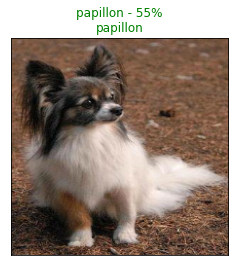

In [48]:
plot(predictions, val_labels, val_images,73)

Now that we've visualized the model's predictions, let's look at the top 10 predictions.

In [49]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 highest prediction confidences along with
  the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="black")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("red")
  else:
    pass

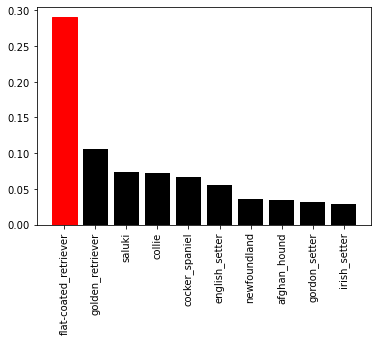

In [50]:
plot_pred_conf(prediction_probabilities=predictions,
               labels=val_labels,
               n=20)

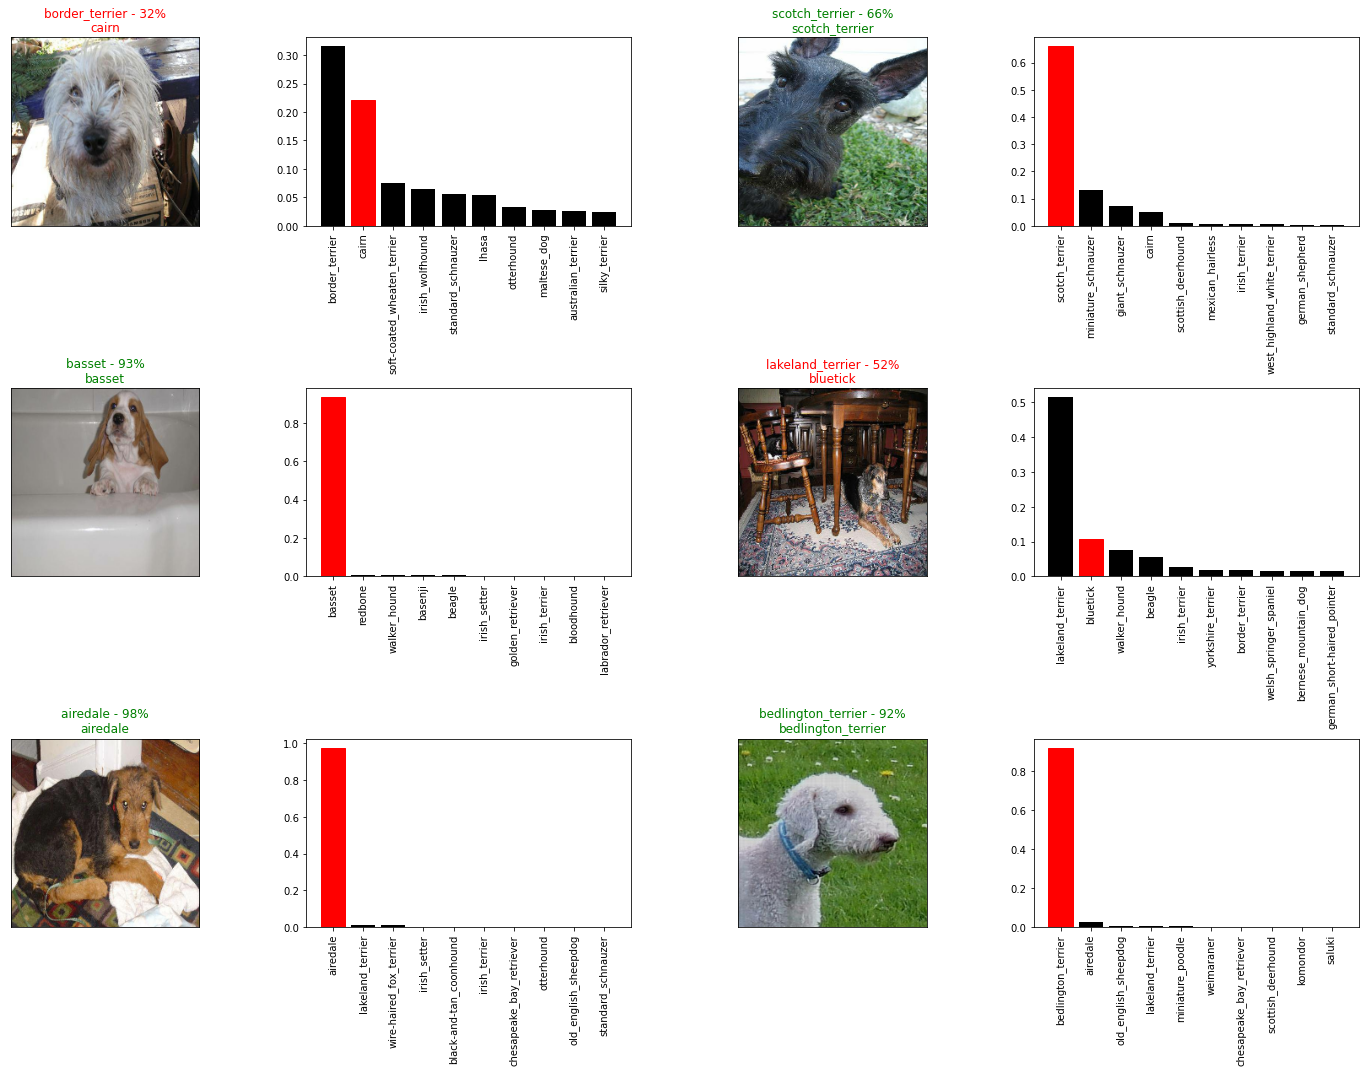

In [51]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot(pred_probs=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

## Saving a model

In [52]:
from datetime import datetime
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("",
                          datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [53]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [54]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-Adam")

Saving model to: 20200828-10421598611338-1000-images-Adam.h5...


'20200828-10421598611338-1000-images-Adam.h5'

# Training a model in full dataset

In [55]:
# Turn full training data in a data batch
full_data = data_batcher(X, y)

Creating training data batches...


In [56]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

Building model with :  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4 ...


Lets make some callbacks too.

In [57]:
# Create full model callbacks
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

Fitting the model on full data.

In [58]:
# Fit the full model to the full training data
full_model.fit(x=full_data,
               epochs=5,
               callbacks=[full_model_early_stopping])

Epoch 1/5
320/320 [==============================] - 54s 169ms/step - loss: 1.3352 - accuracy: 0.6690
Epoch 2/5
320/320 [==============================] - 31s 98ms/step - loss: 0.3971 - accuracy: 0.8821
Epoch 3/5
320/320 [==============================] - 30s 95ms/step - loss: 0.2298 - accuracy: 0.9380
Epoch 4/5
320/320 [==============================] - 33s 102ms/step - loss: 0.1498 - accuracy: 0.9647
Epoch 5/5
320/320 [==============================] - 31s 96ms/step - loss: 0.1050 - accuracy: 0.9781


Let's save this model.

In [59]:
save_model(full_model, suffix="all-images-Adam")

Saving model to: 20200828-10451598611527-all-images-Adam.h5...


'20200828-10451598611527-all-images-Adam.h5'

In [60]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test = "/kaggle/input/dog-breed-identification/test/"
test_filenames = [test + fname for fname in os.listdir(test_path)]

test_filenames[:10]

NameError: name 'test_path' is not defined

In [61]:
# Create test data batch
test_data = data_batcher(test_filenames, test_data=True)

NameError: name 'test_filenames' is not defined

In [62]:
# Make predictions on test data batch using the loaded full model
test_preds = full_model.predict(test_data,
                                             verbose=1)

NameError: name 'test_data' is not defined

In [63]:
# Creating pandas DataFrame with empty columns
subm_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
# Append test image ID's to predictions DataFrame
test = "/kaggle/input/dog-breed-identification/test/"
subm_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test)]
# Add the prediction probabilities to each dog breed column
subm_df[list(unique_breeds)] = test_predictions
subm_df.head()

NameError: name 'test_predictions' is not defined

In [64]:
# Taking a .csv output for submission
subm_df.to_csv("Submissions.csv",
                 index=False)